In [187]:
%reset

In [188]:
# 加载所需的库
import pandas as pd
import numpy as np
from scipy.stats import binom
from scipy.stats import norm
from scipy.stats import chi2
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [189]:
m = 100
l = pd.Series(np.repeat(1,m))
Delta = 1.7
d = 5
Rho = 0.5
n = 300
np.random.seed(1)

## crude simulation

In [190]:
P_crude = list()

for j in range(100):
    L_crude = list()

    for i in range(n):
        z_0 = np.random.normal(loc=0,scale=1)
        u = np.random.uniform()
        Chi_2 = chi2.ppf(q=u, df=d)
        #Chi_2 = np.random.chisquare(df=d,size=m)
        z = pd.Series(np.random.normal(loc=0,scale=1,size=m))
        x = (Rho*z_0 + np.power((1-np.power(Rho,2)),0.5)*z) / np.power(Chi_2/d,0.5)
        L_crude.append(np.sum(l*(x>Delta)))

    L_crude = pd.Series(L_crude)
    p = sum(L_crude>10)/len(L_crude)
    P_crude.append(p)

P_crude = pd.Series(P_crude)

(array([ 2.,  7.,  7., 13., 11., 19., 17., 12.,  7.,  5.]),
 array([0.18      , 0.19133333, 0.20266667, 0.214     , 0.22533333,
        0.23666667, 0.248     , 0.25933333, 0.27066667, 0.282     ,
        0.29333333]),
 <BarContainer object of 10 artists>)

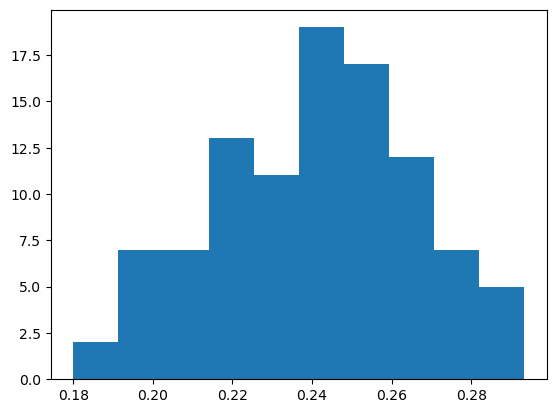

In [191]:
plt.hist(P_crude)

In [192]:
np.mean(P_crude)

0.2408

In [193]:
np.var(P_crude)


0.0006626933333333337

## Antithetic Variates

In [194]:
np.random.seed(1)
P_AV = list()

for j in range(100):
    p_AV = list()
    for i in range(n):
        #生成仿真
        z_0 = np.random.normal(loc=0,scale=1)
        u = np.random.uniform()
        Chi_2 = chi2.ppf(q=u, df=d)
        z = pd.Series(np.random.normal(loc=0,scale=1,size=m))
        x = (Rho*z_0 + np.power((1-np.power(Rho,2)),0.5)*z) \
            / np.power(Chi_2/d,0.5)
        L=np.sum(l*(x>Delta))
        if L > 10:
            p = 1
        else:
            p=0

        #生成Antithetic
        Chi_2_anti = chi2.ppf(q=(1-u), df=d)
        x_anti = (Rho*(-z_0) + np.power((1-np.power(Rho,2)),0.5)*(-z)) \
                 / np.power(Chi_2_anti/d,0.5)
        L_anty = np.sum(l*(x_anti>Delta))
        if L_anty > 10:
            p_anty = 1
        else:
            p_anty=0

        #记录
        p_AV.append((p+p_anty)/2)

    p = np.mean(p_AV)
    P_AV.append(p)

P_AV = pd.Series(P_AV)

(array([ 4.,  8.,  7., 20., 14., 18., 14.,  9.,  4.,  2.]),
 array([0.20833333, 0.21466667, 0.221     , 0.22733333, 0.23366667,
        0.24      , 0.24633333, 0.25266667, 0.259     , 0.26533333,
        0.27166667]),
 <BarContainer object of 10 artists>)

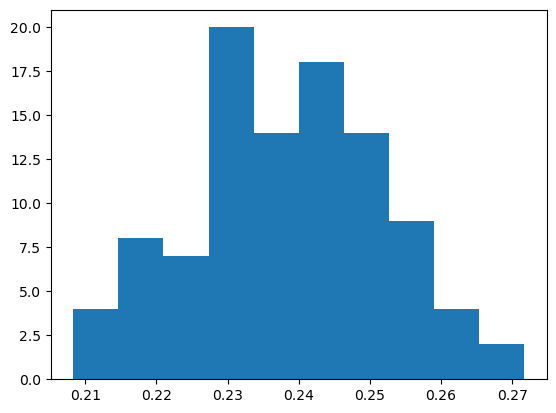

In [195]:
plt.hist(P_AV)

In [196]:
np.mean(P_AV)

0.2382

In [197]:
np.var(P_AV)


0.00017603777777777777

In [198]:
np.var(P_AV)/np.var(P_crude)


0.2656398803535738

## Control variates

In [199]:
np.random.seed(1)
P_CV = list()

for j in range(100):
    L_CV = list()

    for i in range(n):
        z_0 = np.random.normal(loc=0,scale=1)
        u = np.random.uniform()
        Chi_2 = chi2.ppf(q=u, df=d)
        z = pd.Series(np.random.normal(loc=0,scale=1,size=m))
        x = (Rho*z_0 + np.power((1-np.power(Rho,2)),0.5)*z) / np.power(Chi_2/d,0.5)
        L = np.sum(l*(x>Delta))
        if L > 10:
            p = 1
        else:
            p=0

        L_CV.append([p]+[z_0]+[Chi_2-d]+list(z))

        #L_CV.insert(L_CV.shape[1],i,[L]+[z_0]+list(Chi_2-d)+list(z))

    L_CV = pd.DataFrame(L_CV)

    y = L_CV.iloc[:, 0] # 因变量
    x = L_CV.iloc[:, 1:] # 自变量

    model = LinearRegression() # 构建线性模型
    model.fit(x, y) # 自变量在前，因变量在后
    predicts = model.predict(x)
    intercept = model.intercept_
    r = y - predicts + intercept

    p = np.mean(r)
    P_CV.append(p)

P_CV = pd.Series(P_CV)


(array([ 4.,  8., 15., 23., 15., 14.,  6.,  6.,  5.,  4.]),
 array([0.18840696, 0.19860719, 0.20880741, 0.21900763, 0.22920786,
        0.23940808, 0.2496083 , 0.25980853, 0.27000875, 0.28020897,
        0.2904092 ]),
 <BarContainer object of 10 artists>)

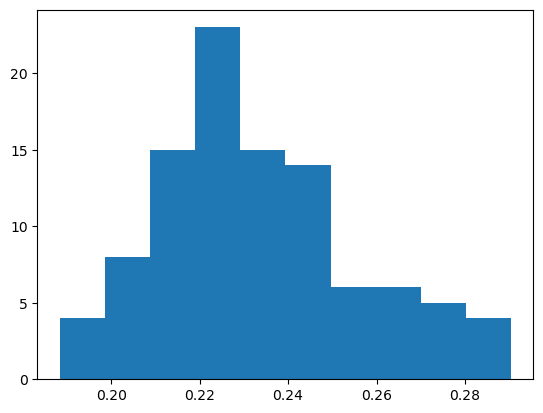

In [200]:
plt.hist(P_CV)

In [201]:
np.mean(P_CV)


0.23327976262877523

In [202]:
np.var(P_CV)


0.0005027419197397793

In [203]:
np.var(P_CV)/np.var(P_crude)

0.7586343402777237

## CONDITIONAL EXPECTATIONS

In [205]:
P_CE = list()

for j in range(100):
    p_CE = list()

    for i in range(n):
        z_0 = np.random.normal(loc=0,scale=1)
        u = np.random.uniform()
        Chi_2 = chi2.ppf(q=u, df=d)

        y = (Delta * np.power(Chi_2/d,0.5) - Rho*z_0 ) / np.power((1-np.power(Rho,2)),0.5)
        p_binom = 1 - norm.cdf(y)
        p = 1 - binom.cdf(9,n=100,p=p_binom)

        p_CE.append(p)

    p = np.mean(p_CE)
    P_CE.append(p)

P_CE = pd.Series(P_CE)


(array([ 5., 11., 17., 19., 14., 11., 11.,  6.,  3.,  3.]),
 array([0.20890842, 0.22082831, 0.2327482 , 0.2446681 , 0.25658799,
        0.26850788, 0.28042777, 0.29234767, 0.30426756, 0.31618745,
        0.32810735]),
 <BarContainer object of 10 artists>)

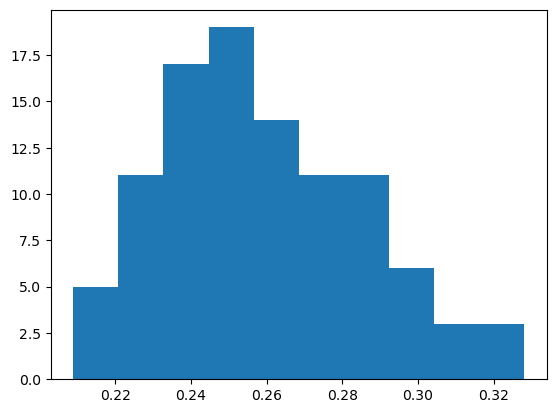

In [206]:
plt.hist(P_CE)

In [207]:
np.mean(P_CE)


0.2590748204639043

In [208]:
np.var(P_CE)


0.000664008118800265

In [209]:
np.var(P_CE)/np.var(P_crude)


1.0019840028574272

In [214]:
P_CE2 = list()
cutoff = norm.ppf(1-10/m)

for j in range(100):
    p_CE2 = list()

    for i in range(n):
        z_0 = np.random.normal(loc=0,scale=1)
        u = np.random.uniform()
        Chi_2 = chi2.ppf(q=u, df=d)

        y = (Delta * np.power(Chi_2/d,0.5) - Rho*z_0 ) / np.power((1-np.power(Rho,2)),0.5)
        if y < cutoff:
            p = 1
        else:
            p = 0

        p_CE2.append(p)

    p = np.mean(p_CE2)
    P_CE2.append(p)

P_CE2 = pd.Series(P_CE2)

(array([ 2.,  6.,  9., 16., 19., 22., 13.,  6.,  5.,  2.]),
 array([0.18666667, 0.199     , 0.21133333, 0.22366667, 0.236     ,
        0.24833333, 0.26066667, 0.273     , 0.28533333, 0.29766667,
        0.31      ]),
 <BarContainer object of 10 artists>)

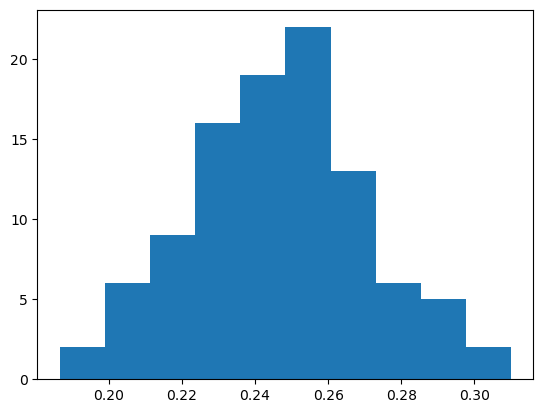

In [215]:
plt.hist(P_CE2)


In [216]:
np.mean(P_CE2)


0.24650000000000008

In [217]:
np.var(P_CE2)


0.0005856388888888888

In [218]:
np.var(P_CE2)/np.var(P_crude)


0.8837253363379066